## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

#Use L2 regulization
def build_reg_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

#Use drop out
def build_dout_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

#Use batch norm
def build_batchNorm_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256

In [7]:
results = {}
methods=['dout','batchNorm','reg']
for method in methods:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with %s" % (method))
    if method=='reg':
        model = build_reg_mlp(input_shape=x_train.shape[1:])
    elif method=='dout':
        model = build_dout_mlp(input_shape=x_train.shape[1:])
    elif method=='batchNorm':
        model = build_batchNorm_mlp(input_shape=x_train.shape[1:])
        
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-%s" % method
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0813 14:02:57.712278 24180 deprecation_wrapper.py:119] From e:\using\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0813 14:02:57.713278 24180 deprecation_wrapper.py:119] From e:\using\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0813 14:02:57.731279 24180 deprecation_wrapper.py:119] From e:\using\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 14:02:57.732279 24180 deprecation_wrapper.py:119] From e:\using\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 14:02:57.734279 24180 deprecation_wrapper.py:1

Experiment with dout
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               

W0813 14:02:58.014295 24180 deprecation.py:323] From C:\Users\Sanga\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 119us/step - loss: 2.0329 - acc: 0.2521 - val_loss: 1.8552 - val_acc: 0.3297
Epoch 2/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.8432 - acc: 0.3332 - val_loss: 1.7419 - val_acc: 0.3729
Epoch 3/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.7884 - acc: 0.3572 - val_loss: 1.7065 - val_acc: 0.3891
Epoch 4/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.7413 - acc: 0.3757 - val_loss: 1.6409 - val_acc: 0.4147
Epoch 5/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.7133 - acc: 0.3854 - val_loss: 1.6245 - val_acc: 0.4216
Epoch 6/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.6825 - acc: 0.3953 - val_loss: 1.5743 - val_acc: 0.4392
Epoch 7/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.6682 - acc: 0.4002 - val_loss: 1.5891 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.6966 - acc: 0.4039 - val_loss: 1.7202 - val_acc: 0.3860
Epoch 2/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.4784 - acc: 0.4774 - val_loss: 1.8490 - val_acc: 0.3717
Epoch 3/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.3809 - acc: 0.5084 - val_loss: 1.7532 - val_acc: 0.3770
Epoch 4/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.3135 - acc: 0.5336 - val_loss: 1.8008 - val_acc: 0.3860
Epoch 5/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.2560 - acc: 0.5535 - val_loss: 1.9904 - val_acc: 0.3343
Epoch 6/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2144 - acc: 0.5710 - val_loss: 1.8756 - val_acc: 0.3925
Epoch 7/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.1676 - acc: 0.5851 - val_loss: 1.6720 - 

Epoch 2/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.8028 - acc: 0.3861 - val_loss: 1.7261 - val_acc: 0.4150
Epoch 3/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.7030 - acc: 0.4184 - val_loss: 1.6623 - val_acc: 0.4244
Epoch 4/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.6350 - acc: 0.4407 - val_loss: 1.6001 - val_acc: 0.4478
Epoch 5/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.5731 - acc: 0.4608 - val_loss: 1.6140 - val_acc: 0.4503
Epoch 6/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.5348 - acc: 0.4753 - val_loss: 1.5859 - val_acc: 0.4573
Epoch 7/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.4962 - acc: 0.4873 - val_loss: 1.5141 - val_acc: 0.4822
Epoch 8/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.4692 - acc: 0.4969 - val_loss: 1.5731 - val_acc: 0.4579
Epoch 9/50
50000/50000 [=================

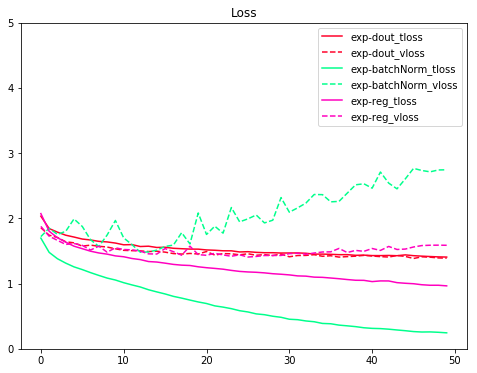

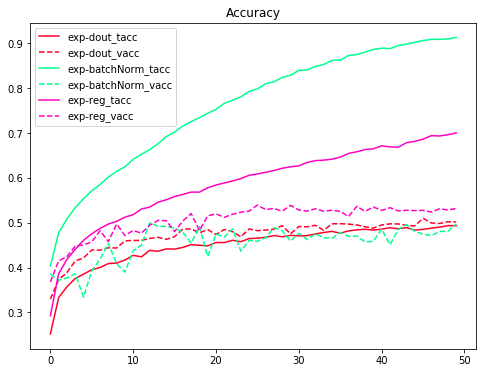

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 3

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond+'_tloss', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond+'_vloss', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond+'_tacc', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond+'_vacc', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
#drop out比較不容易over fitting
#batch norm比較容易over fitting